In [1]:
from pathlib import Path
import matplotlib.pyplot as plt
import torch
import datashader as ds
import colorcet as cc
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd

from ml.data import BuildingDataModule
from ml.train import Surrogate

Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
registry = "ml-for-building-energy-modeling/model-registry"
model = "Global UBEM Shoebox Surrogate with Combined TS Embedder"
tag = "v1"
resource = "model-with-transform-configs.ckpt"

surrogate = Surrogate.load_from_registry(registry, model, tag, resource)


c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'target_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['target_transform'])`.
c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'weather_transform' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['weather_transform'])`.


In [4]:
dm = BuildingDataModule(
    bucket="ml-for-bem",
    remote_experiment="full_climate_zone/v5",
    data_dir="data/lightning",
    climate_array_path=str(Path("data") / "epws" / "global_climate_array.npy"),
    batch_size=32,
    val_batch_mult=32
)
dm.setup(stage=None)
unseen = dm.val_dataloader()[1]

In [5]:
surrogate.model.eval()

# create an empty dataframe with columns matching the target_transform.columns
df_preds = pd.DataFrame(columns=surrogate.target_transform.columns)
df_true = pd.DataFrame(columns=surrogate.target_transform.columns)


with torch.no_grad():
    i = 0
    for features, schedules, weather, targets in tqdm(unseen):
        features = features.cuda()
        schedules = schedules.cuda()
        weather = weather.cuda()
        targets = targets.cuda()
        preds = surrogate.model(features, schedules, weather)
        preds = preds.reshape(targets.shape)
        preds = surrogate.target_transform.inverse_transform(preds)
        targets = surrogate.target_transform.inverse_transform(targets)
        df_preds = pd.concat([ df_preds, pd.DataFrame(preds.cpu().numpy(), columns=surrogate.target_transform.columns) ],axis=0)
        df_true = pd.concat([ df_true, pd.DataFrame(targets.cpu().numpy(), columns=surrogate.target_transform.columns) ], axis=0)


        i += 1
        if i > 100:
            break
df_res = df_preds - df_true
mae = df_res.abs().mean(axis=0)
mbe = df_res.mean(axis=0)
mse = (df_res**2).mean(axis=0)
rmse = np.sqrt(mse)
cvrmse = rmse / df_true.mean(axis=0)*100

df_preds_monthly_zones = df_preds.T.groupby(level=[0,2]).sum().T
df_true_monthly_zones = df_true.T.groupby(level=[0,2]).sum().T
df_res_monthly_zones = df_preds_monthly_zones - df_true_monthly_zones

mse_monthly_zones = (df_res_monthly_zones**2).mean(axis=0)
mae_monthly_zones = df_res_monthly_zones.abs().mean(axis=0)
rmse_monthly_zones = np.sqrt(mse_monthly_zones)
cvrmse_monthly_zones = rmse_monthly_zones / df_true_monthly_zones.mean(axis=0)*100


df_preds_annual = df_preds.T.groupby(by=["KeyValue","Name"]).sum().T
df_true_annual = df_true.T.groupby(by=["KeyValue","Name"]).sum().T
df_res_annual = df_preds_annual - df_true_annual

# compute mae mse rmse cvrmse for annual
mae_annual = df_res_annual.abs().mean(axis=0)
mse_annual = (df_res_annual**2).mean(axis=0)
rmse_annual = np.sqrt(mse_annual)
cvrmse_annual = rmse_annual / df_true_annual.mean(axis=0)*100


  0%|          | 0/86 [00:00<?, ?it/s]

c:\tools\Anaconda3\envs\ml-for-bem-final\lib\site-packages\torch\nn\modules\conv.py:309: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\Convolution.cpp:1004.)
  return F.conv1d(input, weight, bias, self.stride,


In [6]:
monthly_cvrmse_by_zone = np.sqrt((df_res_monthly_zones**2).mean(axis=0).groupby(level=0).mean()) /df_true_monthly_zones.mean(axis=0).groupby(level=0).mean() * 100
monthly_cvrmse_by_zone

KeyValue
Core         8.321941
Perimeter    6.751980
dtype: float32

In [6]:
df_res.abs().T.groupby(level=[0,1]).mean().T

KeyValue      Core           Perimeter          
Name       Cooling   Heating   Cooling   Heating
0         0.493021  0.000000  0.157860  0.000000
1         0.038225  0.111042  0.038086  0.314200
2         0.809079  0.000000  0.609175  0.000000
3         0.382903  0.000000  0.261560  0.000000
4         0.296203  0.000000  0.292287  0.000000
..             ...       ...       ...       ...
382       0.072154  1.217681  0.093394  0.344928
383       0.097029  0.268252  0.096333  0.460572
384       0.000000  0.281555  0.000000  0.356763
385       0.579661  0.046472  0.640471  0.030482
386       0.335156  0.001491  0.261000  0.004302

[87427 rows x 4 columns]

## Annual Plots

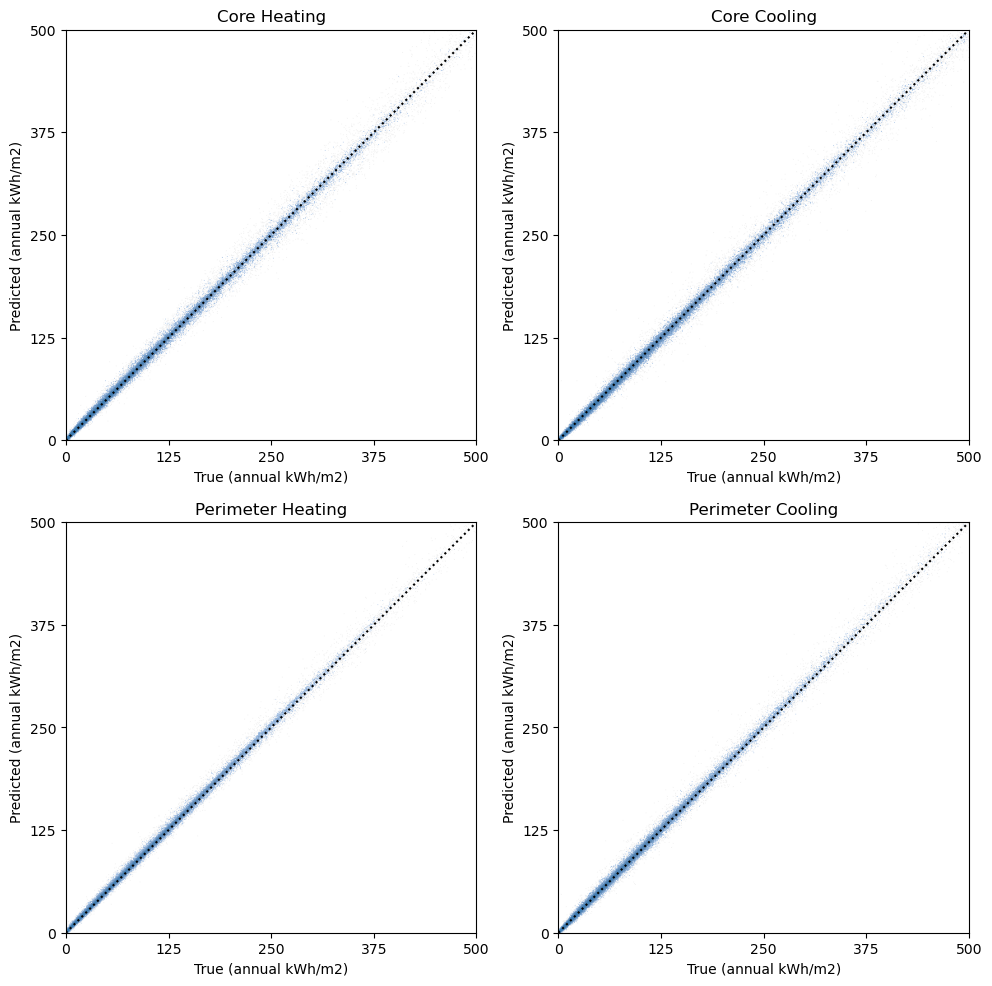

In [7]:
save = False
# bring df_res, df_preds, df_true into a single dataframe, which has the same columns but a new top level in the multi index
df = pd.concat([df_res_annual, df_preds_annual, df_true_annual], keys=['res', 'preds', 'true'], axis=1)

# convert df column names to a flat set of strings
df.columns = df.columns.map('_'.join)

# plt.style.use("dark_background")
plt.style.use("default")
fig, axs = plt.subplots(2,2,figsize=(10,10))
bg_color, cmap = "#202020" , cc.bmy
bg_color, cmap = "#ffffff" , cc.blues
# bg_color , cmap = "#000000", cc.fire
fig.patch.set_facecolor(bg_color)
    
# create a datashader canvas
limits = 500
res = 500
cvs = ds.Canvas(plot_width=res, plot_height=res, x_range=(0,limits), y_range=(0,limits), )
# create a scatterplot of the data
i = 0
for zone in ["Core", "Perimeter"]:
    j = 0
    for end_use in ["Heating","Cooling"]:

        agg = cvs.points(df, (f"true_{zone}_{end_use}"),(f"preds_{zone}_{end_use}"))
        shader = ds.tf.shade(agg, cmap=cmap)
        # create a line from 0,0 to max of df[true_{zone}_{end_use}]
        # line = pd.DataFrame({"x":[0, df[f"true_{zone}_{end_use}"].max()], "y":[0, df[f"true_{zone}_{end_use}"].max()]})
        # line_agg = cvs.line(line, "x","y")
        # shade the line
        # line_shader = ds.tf.shade(line_agg, cmap="white")
        # stack the line on top of the scatterplot
        # shader = ds.tf.stack(shader, line_shader)
        im = ds.tf.set_background(shader, bg_color, f"{zone}_{end_use}")
        im = im.to_pil()
        if save:
            im.save(f"figures/true_vs_preds_{zone}_{end_use}.png")
        # plot im upside down
        axs[i,j].imshow(np.flipud(im),origin='lower')
        axs[i,j].set_title(f"{zone} {end_use}")
        axs[i,j].plot([0,res],[0,res], ":",color="white" if bg_color != "#ffffff" else "black")
        j = j + 1
    i = i + 1
for i in range(2):
    for j in range(2):
        axs[i,j].set_xticks(np.linspace(0,res,5).astype(int),np.linspace(0,limits,5).astype(int))
        axs[i,j].set_yticks(np.linspace(0,res,5).astype(int), np.linspace(0,limits,5).astype(int))
        axs[i,j].set_xlabel("True (annual kWh/m2)")
        axs[i,j].set_ylabel("Predicted (annual kWh/m2)")
        axs[i,j].set_xlim(0,limits)
        axs[i,j].set_ylim(0,limits)
fig.tight_layout()

## Monthly Plots

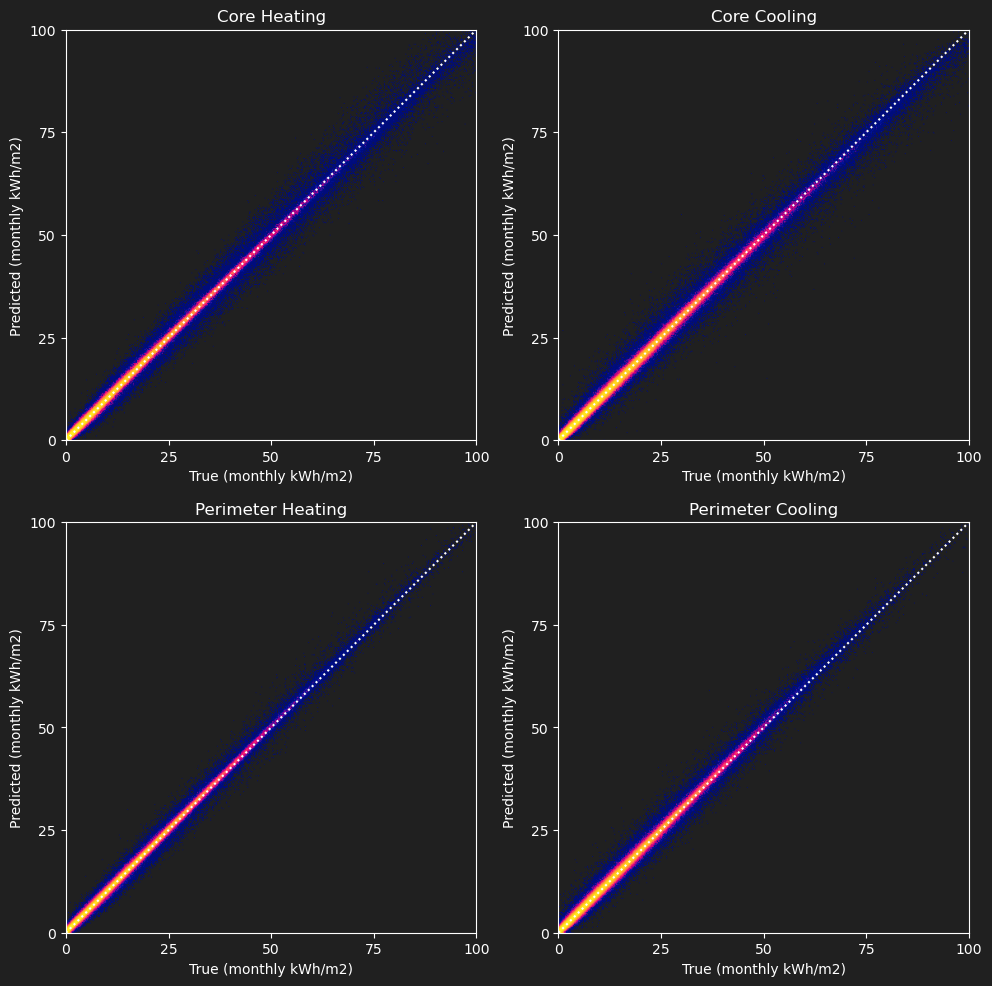

In [8]:
save = False
# bring df_res, df_preds, df_true into a single dataframe, which has the same columns but a new top level in the multi index
df = pd.concat([df_res, df_preds, df_true], keys=['res', 'preds', 'true'], axis=1)
# melt the df
df = df.stack(level=-1)
df = df.reset_index(names=["sample_id","Month"])

# convert df column names to a flat set of strings
df.columns = df.columns.map('_'.join)

plt.style.use("dark_background")
# plt.style.use("default")
fig, axs = plt.subplots(2,2,figsize=(10,10))
bg_color, cmap = "#202020" , cc.bmy
# bg_color, cmap = "#ffffff" , cc.blues
# bg_color , cmap = "#000000", cc.fire
fig.patch.set_facecolor(bg_color)
    
# create a datashader canvas
res = 500
limits = 100
cvs = ds.Canvas(plot_width=res, plot_height=res, x_range=(0,limits), y_range=(0,limits), )
# create a scatterplot of the data
i = 0
for zone in ["Core", "Perimeter"]:
    j = 0
    for end_use in ["Heating","Cooling"]:

        agg = cvs.points(df, (f"true_{zone}_{end_use}"),(f"preds_{zone}_{end_use}"))
        shader = ds.tf.shade(agg, cmap=cmap)
        # create a line from 0,0 to max of df[true_{zone}_{end_use}]
        # line = pd.DataFrame({"x":[0, df[f"true_{zone}_{end_use}"].max()], "y":[0, df[f"true_{zone}_{end_use}"].max()]})
        # line_agg = cvs.line(line, "x","y")
        # shade the line
        # line_shader = ds.tf.shade(line_agg, cmap="white")
        # stack the line on top of the scatterplot
        # shader = ds.tf.stack(shader, line_shader)
        im = ds.tf.set_background(shader, bg_color, f"{zone}_{end_use}")
        im = im.to_pil()
        if save:
            im.save(f"figures/true_vs_preds_{zone}_{end_use}.png")
        # plot im upside down
        axs[i,j].imshow(np.flipud(im),origin='lower')
        axs[i,j].set_title(f"{zone} {end_use}")
        axs[i,j].plot([0,res],[0,res], ":",color="white" if bg_color != "#ffffff" else "black")
        j = j + 1
    i = i + 1
for i in range(2):
    for j in range(2):
        axs[i,j].set_xticks(np.linspace(0,res,5).astype(int),np.linspace(0,limits,5).astype(int))
        axs[i,j].set_yticks(np.linspace(0,res,5).astype(int), np.linspace(0,limits,5).astype(int))
        axs[i,j].set_xlabel("True (monthly kWh/m2)")
        axs[i,j].set_ylabel("Predicted (monthly kWh/m2)")
        axs[i,j].set_xlim(0,res)
        axs[i,j].set_ylim(0,res)
fig.tight_layout()

In [ ]:

import torch
surrogate.model.eval()
import matplotlib.pyplot as plt
plt.style.use("dark_background")
# set plt background to #202020
plt.rcParams['axes.facecolor'] = '#202020'
plt.rcParams['figure.facecolor'] = '#202020'
errs = []
ct = 0
with torch.no_grad():
    i = 0
    for features, schedules, weather, targets in tqdm(unseen):
        features = features.cuda()
        schedules = schedules.cuda()
        weather = weather.cuda()
        targets = targets.cuda()
        preds = surrogate.model(features, schedules, weather)
        hier_shape = preds.shape
        preds = preds.reshape(targets.shape)
        preds = surrogate.target_transform.inverse_transform(preds)
        targets = surrogate.target_transform.inverse_transform(targets)
        preds = preds.cpu().numpy()
        targets = targets.cpu().numpy()
        preds = preds.reshape(hier_shape)
        targets = targets.reshape(hier_shape)
        for samp in range(len(preds)):
            ct = ct + 1
            fig, axs = plt.subplots(1,2,figsize=(8,4.5))
            j = 0
            for zone in ["Perimeter","Core"]:
                k = 0
                for end_use in ["Heating","Cooling"]:
                    ax = axs[j]
                    ix = 2*j + k
                    ax.set_title(f"{zone}")
                    ax.plot(targets[samp,ix],"o",label=f"{end_use} (true)", color = "#ff8888" if end_use == "Heating" else "#9999ff")
                    ax.plot(preds[samp,ix], label=f"{end_use } (pred)", lw=1, color="#ffbbbb" if end_use == "Heating" else "#bbbbff")
                    ax.set_ylim(-1,60)

                    
                    k = k+1
                j = j+1
            
            plt.legend()
            fig.tight_layout()
            if ct > 20:
                break
        break
